<a href="https://colab.research.google.com/github/m4chiavelli/analis-cuaca-rmse-vs-mse/blob/main/analis-cuaca-fix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
# Install PySpark
!pip install pyspark

In [100]:
# Import module
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, when, isnan
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Imputer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [101]:
# Membuka SparkSessioin
spark = SparkSession.builder \
    .appName("Weather Temperature Prediction") \
    .getOrCreate()


In [102]:
!wget https://raw.githubusercontent.com/azar-s91/dataset/master/weatherHistory.csv

--2024-10-15 19:37:05--  https://raw.githubusercontent.com/azar-s91/dataset/master/weatherHistory.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5769361 (5.5M) [text/plain]
Saving to: ‘weatherHistory.csv.4’

weatherHistory.csv. 100%[===================>]   5.50M  --.-KB/s    in 0.1s    

2024-10-15 19:37:05 (41.4 MB/s) - ‘weatherHistory.csv.4’ saved [5769361/5769361]



In [103]:
# Load dataset csv yang sudah di-download
data_url = "weatherHistory.csv"
df = spark.read.csv(data_url, header=True, inferSchema=True)


In [104]:
df.printSchema()

root
 |-- DateTime: string (nullable = true)
 |-- Temperature (C): double (nullable = true)
 |-- Humidity: double (nullable = true)
 |-- Wind Speed (km/h): double (nullable = true)
 |-- Pressure (millibars): double (nullable = true)
 |-- Summary: string (nullable = true)



In [105]:
df.show()

+---------------+---------------+--------+-----------------+--------------------+-------------+
|       DateTime|Temperature (C)|Humidity|Wind Speed (km/h)|Pressure (millibars)|      Summary|
+---------------+---------------+--------+-----------------+--------------------+-------------+
|4/1/06 12:00 AM|    9.472222222|    0.89|          14.1197|             1015.13|Partly Cloudy|
| 4/1/06 1:00 AM|    9.355555556|    0.86|          14.2646|             1015.63|Partly Cloudy|
| 4/1/06 2:00 AM|    9.377777778|    0.89|           3.9284|             1015.94|Mostly Cloudy|
| 4/1/06 3:00 AM|    8.288888889|    0.83|          14.1036|                NULL|Partly Cloudy|
| 4/1/06 4:00 AM|    8.755555556|    0.83|          11.0446|             1016.51|Mostly Cloudy|
| 4/1/06 5:00 AM|    9.222222222|    0.85|          13.9587|             1016.66|Partly Cloudy|
| 4/1/06 6:00 AM|    7.733333333|    0.95|          12.3648|             1016.72|Partly Cloudy|
| 4/1/06 7:00 AM|    8.772222222|    0.8

In [106]:
# Pembersihan Data
# Menghitung rata-rata untuk setiap kolom numerik
numerical_cols = [c for c in df.columns if c not in ['DateTime', 'Summary', 'Precip Type', 'Daily Summary', 'features']]

# Menghitung rata-rata kolom
mean_values = df.select([mean(col(c)).alias(c) for c in numerical_cols]).first() # Use imported functions

# Ganti nilai null, 0, dan NaN dengan rata-rata untuk kolom numerik
for col_name in numerical_cols:
    mean_value = mean_values[col_name]
    df = df.withColumn(col_name, when(
        (col(col_name).isNull()) | (col(col_name) == 0) | (isnan(col(col_name))),
        mean_value).otherwise(col(col_name))) # Use imported functions

# Hapus baris dengan NaN di kolom fitur
features = ['Humidity', 'Wind Speed (km/h)', 'Pressure (millibars)']
df = df.na.drop(subset=features)

Temperature (C)         1.000000
Humidity               -0.635028
Wind Speed (km/h)       0.007357
Pressure (millibars)   -0.299465
Name: Temperature (C), dtype: float64


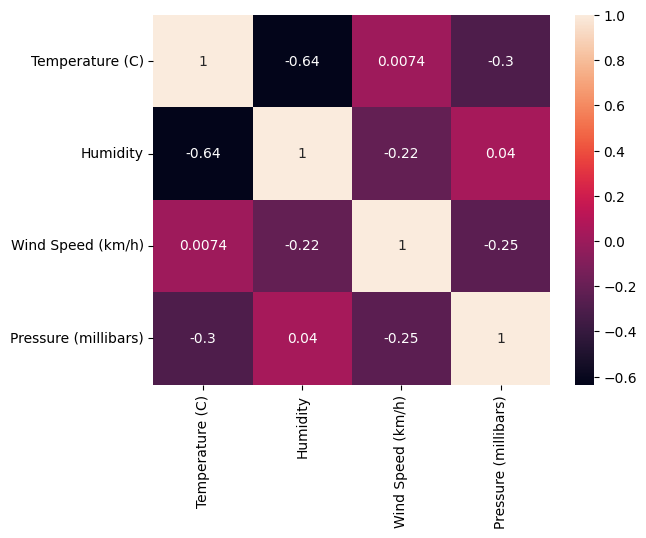

In [107]:
# Perhitungan korelasi
# Hitung nilai korelasi

# Exclude 'DateTime' and other non-numeric columns before calculating correlation
# Ensure 'Temperature (C)' is used as the column name
numeric_df = df.select([c for c in numerical_cols if c in df.columns])
correlation_matrix = numeric_df.toPandas().corr()

# Access the correlation of 'Temperature (C)' instead of 'Temperature'
print(correlation_matrix['Temperature (C)'])

# Visualisasi heatmap
sns.heatmap(correlation_matrix, annot=True)
plt.show()

In [108]:
# Pembuatan Vektor Feature
# Variabel untuk model
features = ['Humidity', 'Wind Speed (km/h)', 'Pressure (millibars)']
assembler = VectorAssembler(inputCols=features, outputCol="features", handleInvalid="skip")  # Change handleInvalid to 'skip'

# Drop the existing 'features' column if it exists
if 'features' in df.columns:
    df = df.drop('features')

# Apply the VectorAssembler to the DataFrame
df = assembler.transform(df)


In [109]:
# Pembagian Training Data
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)


In [110]:
# Create an Imputer to replace NaN values with the mean of the column
# Include the label column 'Temperature (C)' in the Imputer
imputer = Imputer(
    inputCols=["Humidity", "Wind Speed (km/h)", "Pressure (millibars)", "Temperature (C)"],
    outputCols=["Humidity", "Wind Speed (km/h)", "Pressure (millibars)", "Temperature (C)"]
).setStrategy("mean")

# Apply the Imputer to your data
train_data = imputer.fit(train_data).transform(train_data)

# Drop the existing 'features' column before applying VectorAssembler again
train_data = train_data.drop('features')

# Apply VectorAssembler to create the 'features' column
train_data = VectorAssembler(inputCols=features, outputCol="features").transform(train_data)

# Now try fitting the model again
lr_model_multiple = LinearRegression(featuresCol='features', labelCol='Temperature (C)')
lr_model_multiple.fit(train_data)

LinearRegressionModel: uid=LinearRegression_2d4336b57940, numFeatures=3

In [111]:
#Regresi Linier Sederhana (dengan satu fitur, misalnya 'Humidity')

# Drop the existing 'features' column from train_data
train_data_simple = train_data.drop('features')  # Add this line

# Create a new DataFrame with only 'Humidity' and 'Temperature' for simple linear regression
train_data_simple = train_data.select(['Humidity', 'Temperature (C)']) # Add this line

assembler_simple = VectorAssembler(inputCols=['Humidity'], outputCol='features')
train_data_simple = assembler_simple.transform(train_data_simple)  # Transform the new DataFrame

# Similar changes for test_data:
test_data_simple = test_data.select(['Humidity', 'Temperature (C)'])
test_data_simple = assembler_simple.transform(test_data_simple)


lr_model_simple = LinearRegression(featuresCol='features', labelCol='Temperature (C)')  # Use 'Temperature (C)'
lr_model_simple = lr_model_simple.fit(train_data_simple)

In [112]:
# Evaluasi Model
# Prediksi dan evaluasi untuk model Regresi Linier Berganda
# The 'fit' method returns a LinearRegressionModel, which has the 'transform' method
# Assign the result of fit back to lr_model_multiple
lr_model_multiple = lr_model_multiple.fit(train_data)
predictions_multiple = lr_model_multiple.transform(test_data)
evaluator = RegressionEvaluator(labelCol='Temperature (C)', predictionCol='prediction', metricName='rmse') # Change labelCol to 'Temperature (C)'
rmse_multiple = evaluator.evaluate(predictions_multiple)

# Prediksi dan evaluasi untuk model Regresi Linier Sederhana
predictions_simple = lr_model_simple.transform(test_data_simple)
rmse_simple = evaluator.evaluate(predictions_simple)

print(f"RMSE Multiple: {rmse_multiple}, RMSE Simple: {rmse_simple}")

RMSE Multiple: 6.612595270963468, RMSE Simple: 7.358745929447881


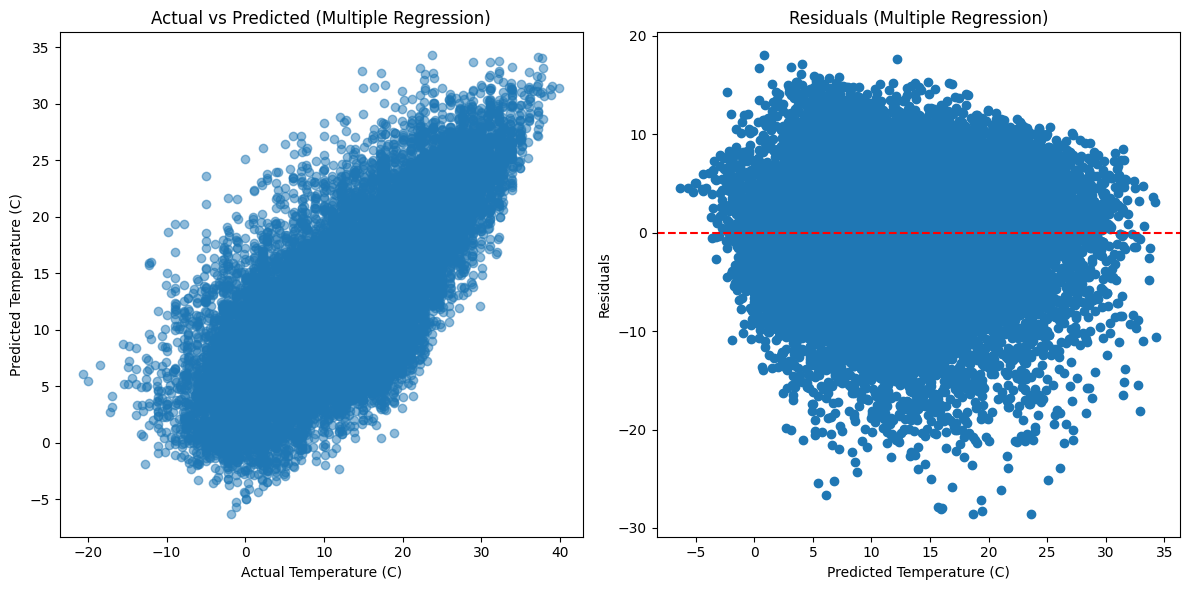

In [113]:
# Visualisasi Hasil
# Konversi hasil prediksi dan kolom suhu asli ke Pandas DataFrame
predictions_df = predictions_multiple.select("Temperature (C)", "prediction").toPandas()

# Visualisasi hasil untuk Regresi Linier Berganda
plt.figure(figsize=(12, 6))

# Plot Actual vs Predicted
plt.subplot(1, 2, 1)
plt.scatter(predictions_df["Temperature (C)"], predictions_df["prediction"], alpha=0.5)
plt.xlabel("Actual Temperature (C)")
plt.ylabel("Predicted Temperature (C)")
plt.title("Actual vs Predicted (Multiple Regression)")

# Visualisasi residual
plt.subplot(1, 2, 2)
plt.scatter(predictions_df["prediction"], predictions_df["Temperature (C)"] - predictions_df["prediction"])
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Temperature (C)")
plt.ylabel("Residuals")
plt.title("Residuals (Multiple Regression)")

plt.tight_layout()  # Tambahkan ini untuk merapikan layout
plt.show()